# Question 3e)

10000 rééchantillons bootstrap générés.
Pour chaque rééchantillon, la VaR Gaussienne et la VaR Empirique ont été calculées.
--------------------------------------------------
--- Résultats de la Simulation Bootstrap ---
           Méthode VaR Taux de Violation Moyen Alpha Cible Distorsion de Taille
            Gaussienne                   3.73%       5.00%               -1.27%
Empirique (Historique)                   5.03%       5.00%                0.03%
--------------------------------------------------


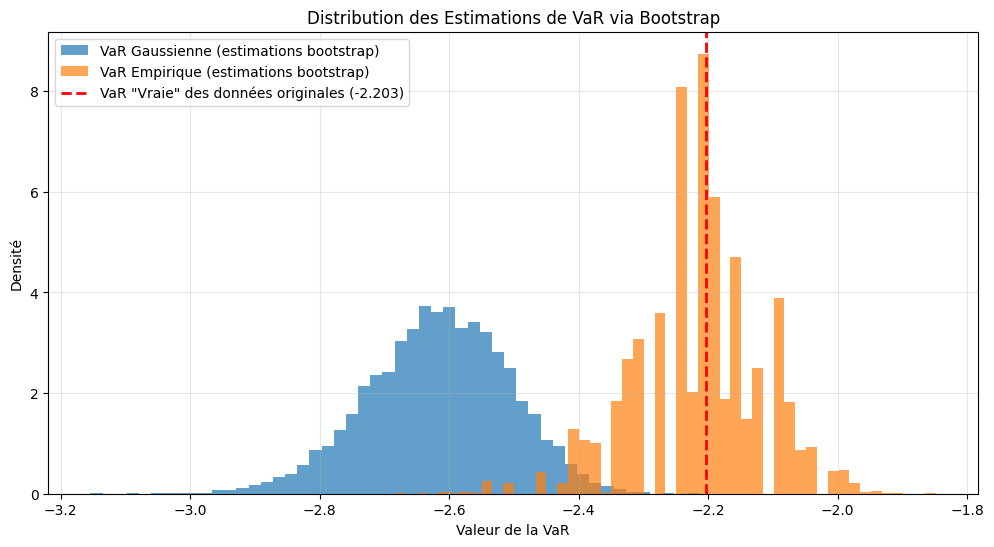

In [12]:
import numpy as np
from scipy.stats import t, norm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Effacer l'output précédent pour éviter les doublons
clear_output(wait=True)

# --- 1. Configuration de la Simulation ---
np.random.seed(123)  # Pour la reproductibilité
n_obs = 2500        # Nombre d'observations dans la série de rendements originale
n_bootstraps = 10000   # Nombre de rééchantillons bootstrap
df_student = 3       # Degrés de liberté pour une distribution proche de la normale
alpha = 0.05          # Niveau de la VaR (5%)

# --- 2. Simulation de la Série de Rendements Initiale ---
# Simuler une série de rendements à partir d'une distribution Student-t
# pour représenter une série avec des queues épaisses.
original_returns = t.rvs(df=df_student, size=n_obs)

# --- 3. Procédure Bootstrap ---
# Listes pour stocker les estimations de VaR de chaque échantillon bootstrap
bootstrap_var_gaussian = []
bootstrap_var_empirical = []

for i in range(n_bootstraps):
    # Générer un rééchantillon bootstrap en tirant avec remise de la série originale
    bootstrap_sample = np.random.choice(original_returns, size=n_obs, replace=True)
    
    # a) Calculer la VaR Gaussienne pour le rééchantillon
    # On suppose (à tort) que l'échantillon suit une loi normale.
    mean_boot = np.mean(bootstrap_sample)
    std_boot = np.std(bootstrap_sample)
    var_gauss = norm.ppf(alpha, loc=mean_boot, scale=std_boot)
    bootstrap_var_gaussian.append(var_gauss)
    
    # b) Calculer la VaR Empirique (Historique) pour le rééchantillon
    # On utilise simplement le percentile de l'échantillon.
    var_emp = np.percentile(bootstrap_sample, 100 * alpha)
    bootstrap_var_empirical.append(var_emp)

print(f"{n_bootstraps} rééchantillons bootstrap générés.")
print("Pour chaque rééchantillon, la VaR Gaussienne et la VaR Empirique ont été calculées.")
print("-" * 50)
# --- 4. Évaluation de la Couverture et de la Distorsion ---
# Convertir les listes en arrays numpy pour les calculs vectoriels
bootstrap_var_gaussian = np.array(bootstrap_var_gaussian)
bootstrap_var_empirical = np.array(bootstrap_var_empirical)

# Calculer la proportion de fois où chaque estimation de VaR est violée par les rendements ORIGINAUX.
# Une violation se produit si un rendement original est inférieur à la VaR estimée.
# Nous calculons le taux de violation moyen sur toutes les estimations de VaR bootstrap.
violation_rates_gaussian = [np.mean(original_returns < var) for var in bootstrap_var_gaussian]
violation_rates_empirical = [np.mean(original_returns < var) for var in bootstrap_var_empirical]

# Taux de violation moyen
mean_violation_rate_gaussian = np.mean(violation_rates_gaussian)
mean_violation_rate_empirical = np.mean(violation_rates_empirical)
mean_violation_rate_empirical = np.mean(violation_rates_empirical)
# Calculer la distorsion de taille (biais)
# C'est la différence entre le taux de violation observé et le taux attendu (alpha).
size_distortion_gaussian = mean_violation_rate_gaussian - alpha
size_distortion_empirical = mean_violation_rate_empirical - alpha

# --- 5. Affichage des Résultats ---
results = pd.DataFrame({
    "Méthode VaR": ["Gaussienne", "Empirique (Historique)"],
    "Taux de Violation Moyen": [mean_violation_rate_gaussian, mean_violation_rate_empirical],
    "Alpha Cible": [alpha, alpha],
    "Distorsion de Taille": [size_distortion_gaussian, size_distortion_empirical]
})

print("--- Résultats de la Simulation Bootstrap ---")
print(results.to_string(index=False, formatters={
    "Taux de Violation Moyen": "{:.2%}".format,
    "Alpha Cible": "{:.2%}".format,
    "Distorsion de Taille": "{:.2%}".format
}))
print("-" * 50)

# Visualisation des distributions des VaR estimées
plt.figure(figsize=(12, 6))
plt.hist(bootstrap_var_gaussian, bins=50, alpha=0.7, label='VaR Gaussienne (estimations bootstrap)', density=True)
plt.hist(bootstrap_var_empirical, bins=50, alpha=0.7, label='VaR Empirique (estimations bootstrap)', density=True)
plt.axvline(np.percentile(original_returns, 100 * alpha), color='red', linestyle='--', lw=2, label=f'VaR "Vraie" des données originales ({np.percentile(original_returns, 100 * alpha):.3f})')
plt.title('Distribution des Estimations de VaR via Bootstrap')
plt.xlabel('Valeur de la VaR')
plt.ylabel('Densité')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
